In [3]:
# Run this to ensure TensorFlow 2.x is used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [4]:
import pandas as pd
import json
import tensorflow as tf
import matplotlib.pyplot as plt 

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from IPython.core.display import display, HTML
from IPython.display import Image 
from statistics import mean

In [5]:
data_url = 'https://github.com/drbonis/icomem-ia-mar-2020/raw/master/data/coronavirus_case_reports.csv'
df = pd.read_csv(data_url)

In [6]:
df.head()

,src,coronavirus,length
0,BACKGROUND: Dengue is the most important human...,0,1634
1,"A 21 year-old man, HIV infected, and with poor...",0,550
2,BACKGROUND: Keratomycosis is one of the most p...,0,1306
3,Congenital toxoplasmosis continues to be a pub...,0,1047
4,The incidence of prosthetic shoulder replaceme...,0,563


In [8]:
df['coronavirus'].value_counts()

0    2012
1      81
Name: coronavirus, dtype: int64

In [9]:
df.shape[0]

2093

In [10]:
html_code = "<div>" + df.loc[df['coronavirus']==0, 'src'].iloc[0] + "</div>"
display(HTML(html_code))

In [11]:
html_code = "<div>" + df.loc[df['coronavirus']==1, 'src'].iloc[0] + "</div>"
display(HTML(html_code))

In [12]:
training_size = round(df.shape[0] * 0.8)
print("Training set: {}, Testing set: {}".format(training_size, df.shape[0] - training_size))

Training set: 1674, Testing set: 419


In [13]:
training_sentences = list(df.iloc[0:training_size]['src'])
testing_sentences = list(df.iloc[training_size:]['src'])

training_labels = list(df.iloc[0:training_size]['coronavirus'])
testing_labels = list(df.iloc[training_size:]['coronavirus'])

In [14]:
tokenizer = Tokenizer(num_words=100000, oov_token="<OOV>")

In [15]:
tokenizer.fit_on_texts(training_sentences)

In [16]:
word_index = tokenizer.word_index

In [17]:
vocab_size = len(list(word_index.keys()))
print("Número de tokens encontrados en el training set: {}".format(vocab_size))

Número de tokens encontrados en el training set: 15810


In [18]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

In [19]:
print("Coronavirus: {}".format(word_index['coronavirus']))

Coronavirus: 348


In [20]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)

In [21]:
print(training_sentences[0][0:100] + " ...")
print("")
print(str(training_sequences[0][0:10]) + "...")
print("")
print("background({}) : dengue({}) is({}) ...".format(word_index['background'], word_index['dengue'], word_index['is']))

BACKGROUND: Dengue is the most important human viral disease transmitted by mosquitoes. It can be as ...

[128, 822, 9, 2, 58, 191, 368, 462, 30, 1501]...

background(128) : dengue(822) is(9) ...


In [22]:
print(training_sentences[0][0:100] + " ...")
print("Number of tokens: {}".format(len(training_sequences[0])))
print("")
print(training_sentences[1][0:100] + " ...")
print("Number of tokens: {}".format(len(training_sequences[1])))
print("")
print(training_sentences[2][0:100] + " ...")
print("Number of tokens: {}".format(len(training_sequences[2])))

BACKGROUND: Dengue is the most important human viral disease transmitted by mosquitoes. It can be as ...
Number of tokens: 235

A 21 year-old man, HIV infected, and with poor adherence to antiretroviral treatment, consulted us d ...
Number of tokens: 81

BACKGROUND: Keratomycosis is one of the most prevalent ophthalmic infections, which needs a specific ...
Number of tokens: 195


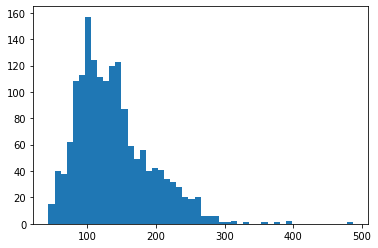

Min: 43, Media: 138, Max: 487


In [23]:
seq_len = [len(x) for x in training_sequences]
plt.hist(seq_len, bins=50)
plt.show()
print("Min: {}, Media: {}, Max: {}".format(min(seq_len), round(mean(seq_len)), max(seq_len)))

In [24]:
training_padded = pad_sequences(training_sequences, maxlen=200, padding='post', truncating='post')

In [25]:
print(training_sentences[0][0:100] + " ...")
print("Number of tokens: {}".format(len(training_sequences[0])))
print(str(training_padded[0][0:100]) + " ...")
print("")
print(training_sentences[0][0:100] + " ...")
print("Number of tokens: {}".format(len(training_sequences[0])))
print(str(training_padded[1][0:100]) + " ...")

BACKGROUND: Dengue is the most important human viral disease transmitted by mosquitoes. It can be as ...
Number of tokens: 235
[ 128  822    9    2   58  191  368  462   30 1501   13 4419   22   48
   27  273   31   22   48   44    6  329    3   45 9130  549  822  162
  822 2388  162    4  822  807   36  121  235  463  249   51   53   67
    6   55 9131  101   13   65 1285    6   23    7  822  162   21   11
   16   32    2   11    3   12  449   29   25 5324   82   41   38    8
    2  385  528    3    2  670  182    3 9132 9133    7   68    3  822
  162  649   13 9134  102   75    7  153 9135    4 9136  219  822   60
   10  114] ...

BACKGROUND: Dengue is the most important human viral disease transmitted by mosquitoes. It can be as ...
Number of tokens: 235
[   5 1084   29   25  184  451  915    4    7  407 2775    8 1573   18
 1085  688   42    8    5 6732 1188   34 1502    4  868  578 1757 9141
 3833   34  201  869   94   10 5326    4 6733 1288    6    2 2585   92
    3    2   21  93

In [26]:
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=200, padding='post', truncating='post')

In [27]:
# Transformamos a numpy para poder usar TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

Vamos a construir una red neuronal con ayuda de la librería Keras compuesta por cuantro capas:

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 128, input_length=200),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


In [29]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          2023680   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 2,027,841
Trainable params: 2,027,841
Non-trainable params: 0
_________________________________________________________________


In [31]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=1)

Train on 1674 samples, validate on 419 samples
Epoch 1/30
1674/1674 [==============================] - 2s 1ms/sample - loss: 0.4598 - accuracy: 0.9558 - val_loss: 0.2190 - val_accuracy: 0.9547
Epoch 2/30
1674/1674 [==============================] - 1s 585us/sample - loss: 0.1507 - accuracy: 0.9630 - val_loss: 0.1580 - val_accuracy: 0.9547
Epoch 3/30
1674/1674 [==============================] - 1s 548us/sample - loss: 0.1256 - accuracy: 0.9630 - val_loss: 0.1392 - val_accuracy: 0.9547
Epoch 4/30
1674/1674 [==============================] - 1s 549us/sample - loss: 0.1053 - accuracy: 0.9630 - val_loss: 0.1160 - val_accuracy: 0.9547
Epoch 5/30
1674/1674 [==============================] - 1s 510us/sample - loss: 0.0836 - accuracy: 0.9630 - val_loss: 0.0908 - val_accuracy: 0.9547
Epoch 6/30
1674/1674 [==============================] - 1s 511us/sample - loss: 0.0600 - accuracy: 0.9725 - val_loss: 0.0662 - val_accuracy: 0.9714
Epoch 7/30
1674/1674 [==============================] - 1s 502us/sa

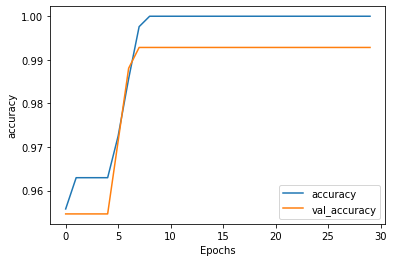

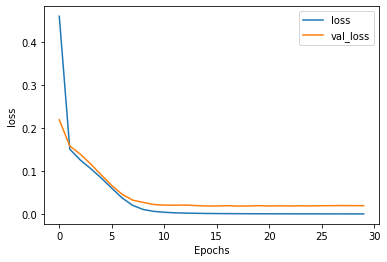

In [32]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [33]:
embeddings_values = model.layers[0]
weights = embeddings_values.get_weights()[0]
print('coronavirus')
print(weights[word_index['coronavirus']])
print("")
print('fever')
print(weights[word_index['fever']])
print("")




coronavirus
[ 0.23423281  0.48361126  0.3795249   0.43192342  0.4341547  -0.4179412
 -0.41750482 -0.41706485 -0.26567578  0.28342918 -0.24819466  0.24638207
  0.25010374 -0.23189297 -0.28102872 -0.13087878 -0.22549742  0.23047681
 -0.40485093 -0.40533814  0.43325338 -0.29429856 -0.4210707  -0.3579994
 -0.29939863 -0.21122047 -0.5003386  -0.32450873  0.3611064  -0.2731484
 -0.35555673  0.41162544  0.2409167  -0.35764307 -0.29350692 -0.3663616
 -0.35194498  0.365179   -0.2932919   0.43423942  0.40226075  0.290116
  0.3246431   0.32660842 -0.26625127 -0.2692335   0.352095   -0.4019278
  0.44707748 -0.43896827 -0.29117057  0.35470834 -0.29998195 -0.20722525
  0.36994508  0.4278877   0.35944355 -0.4236518   0.24504791  0.31959403
 -0.32553378 -0.24087319  0.29820964 -0.3777564   0.31612426 -0.41752017
  0.32937798  0.33842435 -0.31376493 -0.44990006 -0.30790615  0.4661802
 -0.40924448  0.48178276  0.26111716 -0.32861426  0.30146435  0.35131434
 -0.23422173  0.40264955  0.35208425 -0.2057721

In [34]:
diabetes_example = """Diabetic patient with frequent urination,
increased thirst, and increased hunger. Admited to the hospital due to a 
diabetic ketoacidosis episode.
Personal historiy of cardiovascular disease, stroke, chronic kidney disease, 
foot ulcers and diabetic retinopathy."""

sentence = [diabetes_example]
sequence = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequence, maxlen=200, padding='post', truncating='post')
print("Probability of being a patient with coronavirus: {}".format(model.predict(padded)[0][0]))



Probability of being a patient with coronavirus: 0.010321189649403095


In [35]:
coronavirus_example = """76 years old women with fever, cough, flu-like symptons, 
since 3 days admitted to te emergency room.
She has had contact with patients with coronavirus disease 1 week ago. In the
Xray presents evidence of bilateral neumonia. During her stay in the ED she
developed severe respiratory distress and hypoxemia.
A chest TC revealed multifocal nodular 
consolidations with ground-glass opacity halo and mixed consolidation, 
mainly in the peripheral areas.
"""

sentence = [coronavirus_example]
sequence = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequence, maxlen=200, padding='post', truncating='post')
print("Probability of being a patient with coronavirus: {}".format(model.predict(padded)[0][0]))

Probability of being a patient with coronavirus: 0.7867390513420105


In [36]:
clinical_example = """76 years old women with fever, cough, flu-like symptons, 
since 3 days admitted to te emergency room.
In the Xray presents evidence of bilateral neumonia. During her stay in the ED she
developed severe respiratory distress and hypoxemia.
A chest TC revealed multifocal nodular 
consolidations with ground-glass opacity halo and mixed consolidation, 
mainly in the peripheral areas.
"""

sentence = [clinical_example]
sequence = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequence, maxlen=200, padding='post', truncating='post')
print("Probability of being a patient with coronavirus: {}".format(model.predict(padded)[0][0]))

Probability of being a patient with coronavirus: 0.6778934001922607
